In [105]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import re
from sklearn.metrics import classification_report




data = pd.read_csv("/content/weather_data.csv", delimiter = ';')

#Lấy những thông số cần thiết để dự đoán từ data
features = ["temperature", "feelslike", "wind", "gust", "cloud", "humidity", "precipitation", "pressure"]

core_data = data[features].copy()

#loại bỏ data bị lỗi, nhiễu
core_data = core_data.drop(core_data.index[7900:7950])

#Lùi weather label về 3 tiếng
shifted_data = core_data[features].shift(-1)


#Loại các dòng có giá trị NaN do đã shift label
shifted_data = core_data.dropna()

train_size = int(0.6 * len(shifted_data))
train = shifted_data[:train_size]
test = shifted_data[train_size:]

# Khai báo biến dự đoán cho model
predictors = features

# Train model Ridge Regression
reg = Ridge(alpha=0.1)
reg.fit(train[predictors], train["temperature"])

#Trong mô hình hồi quy Ridge, tham số alpha kiểm soát regularization strength.
#Giá trị alpha cao hơn có thể làm giảm độ phức tạp của mô hình và tăng độ lệch nhưng giảm phương sai,
#trong khi giá trị alpha thấp hơn có thể làm tăng độ phức tạp, giảm độ lệch nhưng tăng phương sai.


Ridge(alpha=0.1)

In [106]:
# Tạo ra dự đoán trên tập test
test_predictions = reg.predict(test[predictors])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test["temperature"], test_predictions)

mae_formatted = "{:.6f}".format(mae)

mae_formatted
#Do là model regression và có nhiều data nên việc dự đoán khá là tốt với MAE có giá trị thấp

'0.000033'

In [107]:
#việc dự đoán dựa vào nhiệt độ 3 tiếng trước nhiều nhất, sau đó đến nhiệt độ cảm thấy, gió, ...
#và ngược lại giá trị càng âm càng không quan trọng trong việc dự đoán
for feature, coefficient in zip(features, reg.coef_):
    print(f"{feature}: {coefficient}")

temperature: 0.9999495525235029
feelslike: 2.706211282908811e-05
wind: 7.810201995593493e-07
gust: 1.054328185683855e-06
cloud: 4.033666736698062e-07
humidity: -4.086347054958603e-06
precipitation: -3.01236584183868e-06
pressure: -3.6315928590947145e-06


In [108]:
shifted_data.corr()["temperature"]

temperature      1.000000
feelslike        0.930667
wind             0.230215
gust             0.057105
cloud            0.048952
humidity        -0.811226
precipitation    0.021846
pressure        -0.206062
Name: temperature, dtype: float64

In [109]:
#Tạo ra 1 array để so sánh dự đoán và thực tế
comparison = pd.concat([test["temperature"], pd.Series(test_predictions, index=test.index)], axis=1)
comparison.columns = ["actual", "predictions"]

In [110]:
comparison["diff"] = (comparison["actual"] - comparison["predictions"]).abs()
comparison.sort_values("diff", ascending=False).head()
comparison

#Dự đoán khá là chuẩn

,actual,predictions,diff
5077,32.0,32.000019,0.000019
5078,28.0,27.999987,0.000013
5079,27.0,26.999974,0.000026
5080,26.0,25.999967,0.000033
5081,25.0,25.000028,0.000028
...,...,...,...
8507,29.0,28.999928,0.000072
8508,33.0,32.999931,0.000069
8509,34.0,33.999922,0.000078
8510,31.0,30.999910,0.000090


<Axes: >

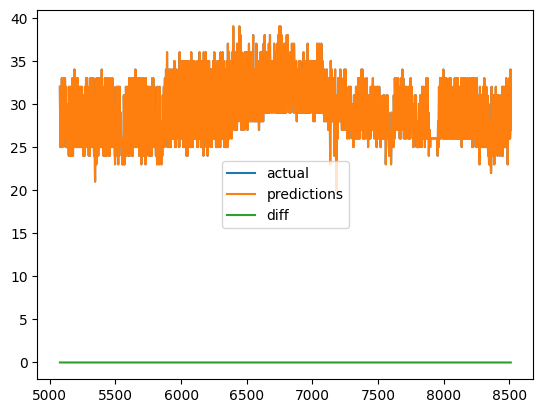

In [111]:
comparison.plot()
#Hồi quy độ dốc là một kỹ thuật chính quy hóa bổ sung thời hạn phạt cho hàm mất mát, giúp
#giảm tác động của các tính năng không liên quan và ngăn chặn quá mức.
#Do sử dụng gần hết thông số để đo đạc dự đoán trong 12 thông số từ data và cách biệt chỉ là 3h.
#và việc sử dụng regression cho việc dự đoán thời tiết là khá tốt nếu chỉ lấy nhiệt độ nên model thì tốt đến khó tin.
